In [1]:
import time
import chess
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.nn import functional as F
import random
import dataset
import model
import trainer
import utils
import dataset
import pickle
import IPython.display as vis
import chess.engine

In [2]:
vocab_size = 30
block_size = 512
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

In [3]:
games = open('data/datasets-cleaned/kingbase_cleaned.txt').read()
pretrain_dataset = dataset.PretrainDataset(games, block_size=block_size)

print(len(pretrain_dataset.stoi))
print(len(pretrain_dataset.itos))
print(pretrain_dataset.stoi)

Data has 592386175 characters, 30 unique.
30
30
{'□': 0, '\n': 1, ' ': 2, '#': 3, '+': 4, '-': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '=': 14, 'B': 15, 'K': 16, 'N': 17, 'O': 18, 'Q': 19, 'R': 20, 'a': 21, 'b': 22, 'c': 23, 'd': 24, 'e': 25, 'f': 26, 'g': 27, 'h': 28, 'x': 29}


In [4]:
# build model config
mconf = model.GPTConfig(
    vocab_size=vocab_size, 
    block_size=block_size, 
    n_layer=12, 
    n_head=32, 
    n_embd=128
)

# load model weights
model = model.GPT(mconf)
model.load_state_dict(torch.load('ckpt/model.iter.params', map_location=torch.device('cpu')))

Number of parameters: 2452736


<All keys matched successfully>

In [5]:
# load dataset
with open('cache/stoi.pkl', 'rb') as f: 
    stoi = pickle.load(f)
    print(len(stoi))
with open('cache/itos.pkl', 'rb') as f:
    itos = pickle.load(f)
    print(len(itos))

30
30


In [6]:
def get_prediction(game_str):

    x = game_str
    x = torch.tensor([stoi[s] for s in x], dtype=torch.long)
    x = x.view(1, -1)

    model.eval()
    with torch.no_grad():

        logits, _ = model(x)
        logits = torch.squeeze(logits)
        y_hat = torch.argmax(logits, dim=-1)
        y_hat = [itos[t.item()] for t in y_hat]

    pred = y_hat[len(game_str) - 1]
    return pred

In [7]:
# declare a chess engine to support our bot if the bot will otherwise make an illegal move; we need to log illegal moves and prevent that from happening in the future
engine = chess.engine.SimpleEngine.popen_uci("/usr/local/bin/stockfish")

In [8]:
def bot_vs_human(starting_pgn=''):
    first_bad_move = -1
    # run inference loop
    game_str = starting_pgn
    bot_move = ''
    board = chess.Board()

    for move in game_str.split():
        board.push_san(move)


    illegal_moves = []
    vis.display(board)
    bot_move_count = 0
    while True:
        #print(game_str)
        user_move = input('Enter move: ')
        
        if user_move == "resign":
            break
        else:
            assert board.parse_san(user_move) in board.legal_moves
            game_str += user_move + ' '
            board.push_san(user_move)
        
        if board.is_checkmate():
            display("CHECKMATE, PLAYER WINS")
            break

        vis.clear_output()
        vis.display(board)

        

        bot_move = ''
        while not bot_move.endswith(' '):
            pred = get_prediction(game_str + bot_move)
            bot_move += pred
        bot_move_count += 1
        try:
            board.push_san(bot_move[:-1])
            illegal_moves.append(0)
        except ValueError:
            illegal_moves.append(1)
            vis.display("ALERT ALERT ALERT: Bot move was illegal.  Computer move substituted.")
            bot_move = engine.play(board, chess.engine.Limit(time=5))
            bot_move_str = board.san(bot_move.move) + " "
            board.push(bot_move.move)
            bot_move = bot_move_str
            if first_bad_move == -1: first_bad_move = bot_move_count

        if board.is_checkmate():
            display("CHECKMATE, BOT WINS")
            break

        #print('Bot plays: {}'.format(bot_move))
        game_str += bot_move
        vis.clear_output()
        vis.display(board)

    return (game_str, illegal_moves, first_bad_move)

In [9]:
def bot_vs_stockfish(starting_pgn='', display_board=True):
    first_bad_move = -1
    # run inference loop
    game_str = starting_pgn
    bot_move = ''
    board = chess.Board()

    for move in game_str.split():
        board.push_san(move)

    illegal_moves = []
    if display_board:
        vis.display(board)
    bot_move_count = 0
    while True:
        #print(game_str)
        comp_move = engine.play(board, chess.engine.Limit(time=0.05))
        game_str += board.san(comp_move.move) + ' '
        board.push(comp_move.move)
        
        if board.is_checkmate():
            if display_board:
                vis.clear_output()
                vis.display(board)
                display("CHECKMATE, STOCKFISH WINS")
            break
        if display_board:
            vis.clear_output()
            vis.display(board)

        

        bot_move = ''
        while not bot_move.endswith(' '):
            pred = get_prediction(game_str + bot_move)
            bot_move += pred
        bot_move_count += 1
        try:
            board.push_san(bot_move[:-1])
            illegal_moves.append(0)
        except ValueError:
            illegal_moves.append(1)
            if display_board:
                vis.display("ALERT ALERT ALERT: Bot move was illegal.  Computer move substituted.")
            bot_move = engine.play(board, chess.engine.Limit(time=0.05))
            bot_move_str = board.san(bot_move.move) + " "
            board.push(bot_move.move)
            bot_move = bot_move_str
            if first_bad_move == -1: first_bad_move = bot_move_count

        if board.is_checkmate():
            if display_board:
                vis.clear_output()
                vis.display(board)
                display("CHECKMATE, BOT WINS")
            break

        #print('Bot plays: {}'.format(bot_move))
        game_str += bot_move
        if display_board:
            vis.clear_output()
            vis.display(board)

    return (game_str, illegal_moves, first_bad_move)

In [97]:
num_illegal_moves = []
first_illegal_move = []
total_black_moves = []
for i in tqdm(range(1000)):
    game_str, illegal_moves, first_bad_move = bot_vs_stockfish(display_board=False)
    black_moves = int(len(game_str.split()) / 2)
    total_black_moves.append(black_moves)
    first_illegal_move.append(first_bad_move)
    num_illegal_moves.append(sum(illegal_moves))

 62%|██████▏   | 619/1000 [1:48:23<1:06:43, 10.51s/it]


OSError: [Errno 24] Too many open files

In [98]:
print(f'Analyzed {i + 1} games...')
print('On average, ChePT made:')
print(f'\t\t\t{int(np.mean(total_black_moves))} moves per game.')
print(f'\t\t\tFirst illegal move on move {int(np.mean(first_illegal_move))}.')
print(f'\t\t\t{int(np.mean(num_illegal_moves))} illegal moves per game.')

print('')
percent = np.round(np.mean(np.array(num_illegal_moves) / np.array(total_black_moves)), 4) * 100
print(f'ChePT makes an illegal move {percent}% of the time')

Analyzed 620 games...
On average, ChePT made:
			30 moves per game.
			First illegal move on move 17.
			6 illegal moves per game.

ChePT makes an illegal move 19.040000000000003% of the time


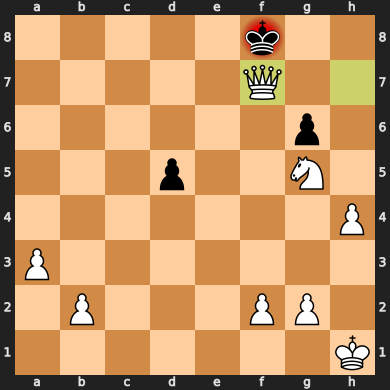

'CHECKMATE, STOCKFISH WINS'

'e4 c5 Nf3 d6 Bb5+ Bd7 Bxd7+ Qxd7 O-O Nc6 Re1 Nf6 h3 g6 c3 Bg7 d4 cxd4 cxd4 d5 e5 Ne4 Nbd2 Nxd2 Bxd2 O-O Rc1 Rfc8 h4 Na5 Rxc8+ Rxc8 Bxa5 Qf5 e6 fxe6 Bc3 Qf7 Kh1 Rc7 Qa4 Rc8 a3 Qf5 Qxa7 e5 dxe5 Qxe5 Bxe5 Bxe5 Qxb7 Bf6 Qxc8+ Kg7 Qd7 Kf7 Ng5+ Kg7 Rxe7+ Bxe7 Qxe7+ Kg8 Qxh7+ Kf8 Qf7# '

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0]

'Num Black Moves:'

32

'Num White Moves:'

33

'First Illegal Move:'

17

'Total Illlegal Moves:'

7

In [88]:
game_str, illegal_moves, first_bad_move = bot_vs_stockfish()
vis.display(game_str)
vis.display(illegal_moves)
black_moves = int(len(game_str.split()) / 2)
white_moves = int((len(game_str.split()) + 1) / 2)
vis.display("Num Black Moves:", black_moves)
vis.display("Num White Moves:", white_moves)
vis.display("First Illegal Move:", first_bad_move)
vis.display("Total Illlegal Moves:", sum(illegal_moves))